# Time travel
let's show how LangGraph supports debugging by viewing, re-playing, and even forking from past states.

In [1]:
from langchain.chat_models import init_chat_model
llm = init_chat_model(
    "anthropic.claude-3-haiku-20240307-v1:0",
    model_provider="bedrock_converse",
)

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

llm_with_tools = llm.bind_tools(tools)

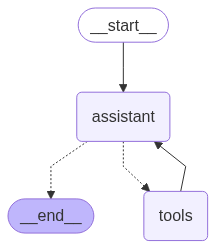

In [2]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [3]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================

[{'type': 'tool_use', 'name': 'multiply', 'input': {'a': 2, 'b': 3}, 'id': 'tooluse_pybqxBbTR9KQdYimKgHTfw'}]
Tool Calls:
  multiply (tooluse_pybqxBbTR9KQdYimKgHTfw)
 Call ID: tooluse_pybqxBbTR9KQdYimKgHTfw
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

Okay, the result of multiplying 2 and 3 is 6.


### Browsing History
We can use get_state to look at the current state of our graph, given the thread_id!

In [5]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='c5594a75-7dea-4676-a686-15226344022a'), AIMessage(content=[{'type': 'tool_use', 'name': 'multiply', 'input': {'a': 2, 'b': 3}, 'id': 'tooluse_pybqxBbTR9KQdYimKgHTfw'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '54caac82-424a-4ef8-a401-579f2daed4f9', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Tue, 22 Jul 2025 22:25:03 GMT', 'content-type': 'application/json', 'content-length': '270', 'connection': 'keep-alive', 'x-amzn-requestid': '54caac82-424a-4ef8-a401-579f2daed4f9'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': [553]}, 'model_name': 'anthropic.claude-3-haiku-20240307-v1:0'}, id='run--1bae8995-2bf6-4fa1-ac71-a58b266e2f90-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'tooluse_pybqxBbTR9KQdYimKgHTfw', 'type': 'tool_call'}], usage_metadata={'input_tokens': 530, 'output_tokens':

In [6]:
#  We can also browse the state history of our agent.
all_states = [s for s in graph.get_state_history(thread)]

In [8]:
len(all_states)

5

In [ ]:
#  All the messages. The first output is the last state that has the result of the running graph 
all_states


[StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='c5594a75-7dea-4676-a686-15226344022a'), AIMessage(content=[{'type': 'tool_use', 'name': 'multiply', 'input': {'a': 2, 'b': 3}, 'id': 'tooluse_pybqxBbTR9KQdYimKgHTfw'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '54caac82-424a-4ef8-a401-579f2daed4f9', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Tue, 22 Jul 2025 22:25:03 GMT', 'content-type': 'application/json', 'content-length': '270', 'connection': 'keep-alive', 'x-amzn-requestid': '54caac82-424a-4ef8-a401-579f2daed4f9'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': [553]}, 'model_name': 'anthropic.claude-3-haiku-20240307-v1:0'}, id='run--1bae8995-2bf6-4fa1-ac71-a58b266e2f90-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'tooluse_pybqxBbTR9KQdYimKgHTfw', 'type': 'tool_call'}], usage_metadata={'input_tokens': 530, 'output_tokens'

In [ ]:
# one to last message is actually the first human message
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='c5594a75-7dea-4676-a686-15226344022a')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0674ab-5f1a-6d67-8000-7157baef4844'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}, 'thread_id': '1'}, created_at='2025-07-22T22:25:02.624068+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0674ab-5f16-6cb5-bfff-2c31ef29e010'}}, tasks=(PregelTask(id='970b39a7-7a75-6efd-bcd6-5fb658d600b7', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content=[{'type': 'tool_use', 'name': 'multiply', 'input': {'a': 2, 'b': 3}, 'id': 'tooluse_pybqxBbTR9KQdYimKgHTfw'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '54caac82-424a-4ef8-a401-579f2daed4f9', 'HTTPStatusCode': 20

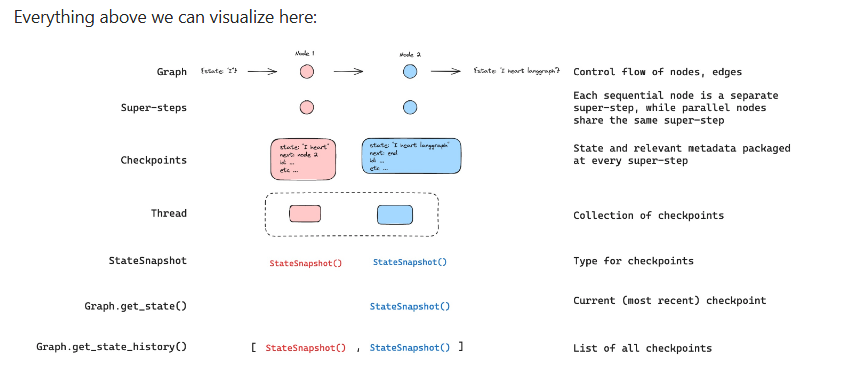

### Replaying

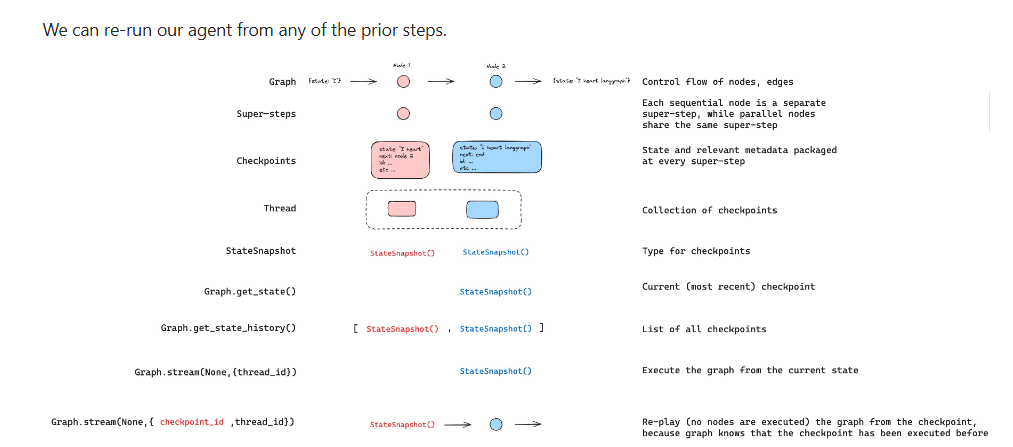

In [20]:
to_replay = all_states[-2]

In [21]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='c5594a75-7dea-4676-a686-15226344022a')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0674ab-5f1a-6d67-8000-7157baef4844'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}, 'thread_id': '1'}, created_at='2025-07-22T22:25:02.624068+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0674ab-5f16-6cb5-bfff-2c31ef29e010'}}, tasks=(PregelTask(id='970b39a7-7a75-6efd-bcd6-5fb658d600b7', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content=[{'type': 'tool_use', 'name': 'multiply', 'input': {'a': 2, 'b': 3}, 'id': 'tooluse_pybqxBbTR9KQdYimKgHTfw'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '54caac82-424a-4ef8-a401-579f2daed4f9', 'HTTPStatusCode': 20

In [22]:
to_replay.next

('assistant',)

In [23]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0674ab-5f1a-6d67-8000-7157baef4844'}}

To replay from here, we simply pass the config back to the agent!

The graph knows that this checkpoint has aleady been executed.

It just re-plays from this checkpoint!

In [24]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================

[{'type': 'text', 'text': 'Here is the result of multiplying 2 and 3:'}, {'type': 'tool_use', 'name': 'multiply', 'input': {'a': 2, 'b': 3}, 'id': 'tooluse_aP2x6KMmSCiz9rOspksftg'}]
Tool Calls:
  multiply (tooluse_aP2x6KMmSCiz9rOspksftg)
 Call ID: tooluse_aP2x6KMmSCiz9rOspksftg
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

Okay, the result of multiplying 2 and 3 is 6.


Now, we can see our current state after the agent re-ran.

### Forking
What if we want to run from that same step, but with a different input.

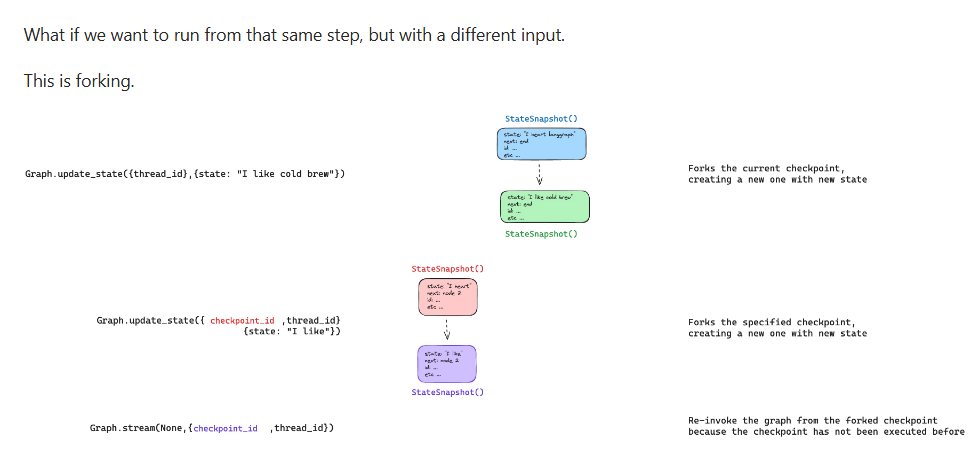

In [25]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='c5594a75-7dea-4676-a686-15226344022a')]

In [26]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0674ab-5f1a-6d67-8000-7157baef4844'}}

Let's modify the state at this checkpoint.

We can just run update_state with the checkpoint_id supplied.

Remember how our reducer on messages works:

It will append, unless we supply a message ID.
We supply the message ID to overwrite the message, rather than appending to state!
So, to overwrite the the message, we just supply the message ID, which we have to_fork.values["messages"].id

In [27]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='Multiply 5 and 3', 
                               id=to_fork.values["messages"][0].id)]},
)

In [28]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0674f0-3496-6ac2-8001-257b345fb927'}}

This creates a new, forked checkpoint.

But, the metadata - e.g., where to go next - is perserved!

We can see the current state of our agent has been updated with our fork.

In [ ]:
all_states = [state for state in graph.get_state_history(thread) ]
# the last added state
all_states[0].values["messages"]

[HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='c5594a75-7dea-4676-a686-15226344022a')]

In [32]:
all_states

[StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='c5594a75-7dea-4676-a686-15226344022a')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0674f0-3496-6ac2-8001-257b345fb927'}}, metadata={'source': 'update', 'step': 1, 'parents': {}, 'thread_id': '1'}, created_at='2025-07-22T22:55:50.370562+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0674ab-5f1a-6d67-8000-7157baef4844'}}, tasks=(PregelTask(id='5f57c560-1052-dd1e-620f-660c8ba18fc9', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='c5594a75-7dea-4676-a686-15226344022a'), AIMessage(content=[{'type': 'text', 'text': 'Here is the result of multiplying 2 and 

In [ ]:
#  A new checkpoint is created for this update. Only one message will be in state with a new checkpoint ID
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='c5594a75-7dea-4676-a686-15226344022a')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0674f0-3496-6ac2-8001-257b345fb927'}}, metadata={'source': 'update', 'step': 1, 'parents': {}, 'thread_id': '1'}, created_at='2025-07-22T22:55:50.370562+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0674ab-5f1a-6d67-8000-7157baef4844'}}, tasks=(PregelTask(id='5f57c560-1052-dd1e-620f-660c8ba18fc9', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

Now, when we stream, the graph knows this checkpoint has never been executed.

So, the graph runs, rather than simply re-playing.

In [34]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 3
================================== Ai Message ==================================

[{'type': 'tool_use', 'name': 'multiply', 'input': {'a': 5, 'b': 3}, 'id': 'tooluse_TjdIIlZ4SKKAlUc5qSW9VA'}]
Tool Calls:
  multiply (tooluse_TjdIIlZ4SKKAlUc5qSW9VA)
 Call ID: tooluse_TjdIIlZ4SKKAlUc5qSW9VA
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

Okay, great! 5 multiplied by 3 is 15.


In [ ]:
#  this is the full state
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='c5594a75-7dea-4676-a686-15226344022a'), AIMessage(content=[{'type': 'tool_use', 'name': 'multiply', 'input': {'a': 5, 'b': 3}, 'id': 'tooluse_TjdIIlZ4SKKAlUc5qSW9VA'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': 'a52336fc-a09b-473a-84f7-6d9e1331f368', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Tue, 22 Jul 2025 23:09:38 GMT', 'content-type': 'application/json', 'content-length': '270', 'connection': 'keep-alive', 'x-amzn-requestid': 'a52336fc-a09b-473a-84f7-6d9e1331f368'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': [633]}, 'model_name': 'anthropic.claude-3-haiku-20240307-v1:0'}, id='run--29472865-fe00-4df9-b7e5-371ff9d6bf13-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 3}, 'id': 'tooluse_TjdIIlZ4SKKAlUc5qSW9VA', 'type': 'tool_call'}], usage_metadata={'input_tokens': 530, 'output_tokens':

In [36]:
all_states = [state for state in graph.get_state_history(thread) ]

In [37]:
all_states

[StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='c5594a75-7dea-4676-a686-15226344022a'), AIMessage(content=[{'type': 'tool_use', 'name': 'multiply', 'input': {'a': 5, 'b': 3}, 'id': 'tooluse_TjdIIlZ4SKKAlUc5qSW9VA'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': 'a52336fc-a09b-473a-84f7-6d9e1331f368', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Tue, 22 Jul 2025 23:09:38 GMT', 'content-type': 'application/json', 'content-length': '270', 'connection': 'keep-alive', 'x-amzn-requestid': 'a52336fc-a09b-473a-84f7-6d9e1331f368'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': [633]}, 'model_name': 'anthropic.claude-3-haiku-20240307-v1:0'}, id='run--29472865-fe00-4df9-b7e5-371ff9d6bf13-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 3}, 'id': 'tooluse_TjdIIlZ4SKKAlUc5qSW9VA', 'type': 'tool_call'}], usage_metadata={'input_tokens': 530, 'output_tokens'